# Part 1, perfect features

In [1]:
import time
import os
import sys
import gc
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
# Path to the dataset
_START_PATH = os.path.join("..", "input", "competitive-data-science-predict-future-sales")

items = pd.read_csv(os.path.join(_START_PATH, "items.csv"))
shops = pd.read_csv(os.path.join(_START_PATH, "shops.csv"))
cats = pd.read_csv(os.path.join(_START_PATH, "item_categories.csv"))
train = pd.read_csv(os.path.join(_START_PATH, "sales_train.csv"))

# set index to ID to avoid droping it later
test  = pd.read_csv(os.path.join(_START_PATH, "test.csv")).set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration we decided to remove items with price > 100000 and sales > 1001 (1000 also works fine here).

Note:
1. ```item_cnt_day``` - The number of products sold in a day. We are trying to predict a monthly amount of this measure.
1. ```item_price``` - The current price of an item

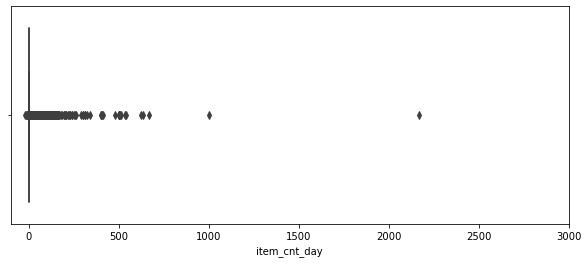

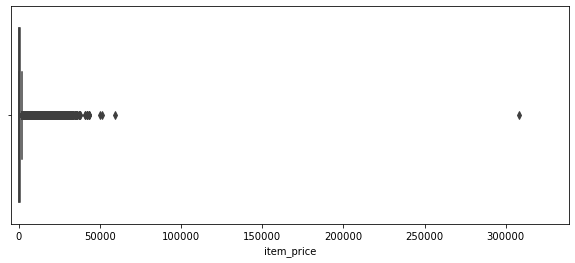

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min() - 5000, train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [6]:
print("For the column: 'item_cnt_day':")
print("Min:", train.item_cnt_day.min())
print("Max:", train.item_cnt_day.max())
print("Range:", train.item_cnt_day.max() - train.item_cnt_day.min())

For the column: 'item_cnt_day':
Min: -22.0
Max: 2169.0
Range: 2191.0


In [7]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

In [8]:
print("For the column: 'item_price':")
print("Min:", train.item_price.min())
print("Max:", train.item_price.max())
print("Range:", train.item_price.max() - train.item_price.min())

For the column: 'item_price':
Min: -1.0
Max: 59200.0
Range: 59201.0


There is one item with price below zero. Fill it with median.
Try mean at the moment

In [9]:
_cond_1 = (train.shop_id == 32)
_cond_2 = (train.item_id == 2973)
_cond_3 = (train.date_block_num == 4)
_cond_4 = (train.item_price > 0)

median = train[_cond_1 & _cond_2 & _cond_3 & _cond_4].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

# Using mean instead of the median does not improve the results
# mean_val = train[_cond_1 & _cond_2 & _cond_3 & _cond_4].item_price.mean()
# train.loc[train.item_price<0, 'item_price'] = mean_val

Several shops are duplicates of each other (according to their name). Hence we fixed this in the train and test set.

In [10]:
# Shop Name: Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Shop Name: Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Shop Name: Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
    - For example, for the entry in the column ```shop_name```:
        1. ```"Волжский ТЦ ""Волга Молл"""```
            * ```"Волжский ТЦ``` is the name of the city
            * ```Волга Молл``` is the name of the shop
* Each category contains type and subtype in its name.
    - For example, for the entry in the column ```item_category_name```:
        1. ```Игровые консоли - PSVita```
            * ```Игровые консоли``` is the type
            * ```PSVita``` is the subtype

In [11]:
# Check the Column Names of the shops Dataframe
print(f"Column Names of the shops Dataframe: {shops.columns.tolist()}")

# Check the Column Names of the cats Dataframe
print(f"Column Names of the cats Dataframe: {cats.columns.tolist()}")

Column Names of the shops Dataframe: ['shop_name', 'shop_id']
Column Names of the cats Dataframe: ['item_category_name', 'item_category_id']


In [12]:
# We correct the name of the city the store is located in, with the below name
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

# We correct the name of the city, with the below name
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

# In general, we remove the '!' character from the city name
shops["city"] = shops.city.apply(lambda x: str.replace(x, '!', ''))

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [13]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# If the subtype is nan then reuse the type as the subtype as well
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

print(cats.head())

# We will only be using the columns: item_category_id, type_code and subtype_code
# for our model
cats = cats[['item_category_id','type_code', 'subtype_code']]

        item_category_name  item_category_id                       split  \
0  PC - Гарнитуры/Наушники                 0  [PC ,  Гарнитуры/Наушники]   
1         Аксессуары - PS2                 1         [Аксессуары ,  PS2]   
2         Аксессуары - PS3                 2         [Аксессуары ,  PS3]   
3         Аксессуары - PS4                 3         [Аксессуары ,  PS4]   
4         Аксессуары - PSP                 4         [Аксессуары ,  PSP]   

         type  type_code             subtype  subtype_code  
0          PC          0  Гарнитуры/Наушники            29  
1  Аксессуары          1                 PS2             9  
2  Аксессуары          1                 PS3            10  
3  Аксессуары          1                 PS4            11  
4  Аксессуары          1                 PSP            13  


In [14]:
# We drop the column item_name as already have all the important information for prediction
# in the item_category_id column
items.drop(['item_name'], axis=1, inplace=True)

In [15]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [16]:
# The column item_id has the exact same values in the exact same positions as the default index column
all(items.index == items.item_id)

True

In [17]:
items = items.set_index("item_id")

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new as compared to the train. Hence, for most of the items in the test set, the target value should be zero. 
On the other hand, the train set contains only pairs which were sold or returned in the past.

Hence, the main idea here is to calculate the monthly sales and **extend it with zero sales** for each of the unique pair observed within the month. This way the train data will be similar to test data.

In [18]:
len(test) == test.shape[0]

True

In [19]:
# Set of unique items in test set
a = set(test.item_id)

# Set of unique items which are common to the test and train set
b = set(test.item_id).intersection(set(train.item_id))

# Number of unique items in the test set
c = len(list(set(test.item_id)))

# Total number of rows in the test set
d = test.shape[0]

len(list(a - b)), c, d

(363, 5100, 214200)

In [20]:
ts = time.time()  # Start time of this cell's execution

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
temp = matrix
# Converting the list of numpy arrays into a DataFrame
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# Setting the type for the various columns of the DataFrame
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols,inplace=True)

# Time taken to complete this operation
time.time() - ts

21.549246311187744

In [21]:
# temp

In [22]:
# np.vstack(temp)

In [23]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


Aggregate the train set by using the shop/item pairs to calculate target aggregates, then perform <b>clip(0,20)</b> on the target value. This way the train target will be similar to the test predictions.

**NOTE:** We use floats instead of ints for ```item_cnt_month``` to avoid downcasting it after concatination with the test set later. If it would be **int16**, after concatination with NaN values it becomes **int64**, but **float16** becomes **float16** even with **NaNs**.

In [24]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [25]:
ts = time.time()  # Start time of this cell's execution

group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0, 20) # We clip target in this range as given in the challenge description
                                .astype(np.float16))

time.time() - ts  # Time taken for this cell to execute

5.808024168014526

## Test set
Append test pairs to the matrix.

In [26]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [27]:
ts = time.time()  # Start time of this cell's execution

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)  # 34th month

time.time() - ts  # Time taken for this cell to execute

0.06378483772277832

## Shops/Items/Cats features

In [28]:
ts = time.time()  # Start time of this cell's execution

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
# matrix = pd.merge(matrix, items, on=['item_id'], how='left')

matrix = pd.merge(matrix, items, left_on=['item_id'], right_index=True, how='left')

matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

time.time() - ts  # Time taken for this cell to execute

3.911949872970581

## Target lags

In [29]:
LAG_LIST = [1, 2, 3, 6, 12]
# LAG_LIST = [1, 2, 3, 4, 5, 12]

In [30]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [31]:
ts = time.time()  # Start time of this cell's execution

matrix = lag_feature(matrix, LAG_LIST, 'item_cnt_month')

time.time() - ts  # Time taken for this cell to execute

36.31277942657471

## Mean encoded features

In [32]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

10.659048795700073

In [33]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, LAG_LIST, 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

42.18901300430298

In [34]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, LAG_LIST, 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

43.41386365890503

In [35]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

14.568145275115967

In [36]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

15.351285219192505

In [37]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

15.453051090240479

In [38]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

16.002323150634766

In [39]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

15.6507089138031

In [40]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

25.021795988082886

In [41]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

15.991777420043945

In [42]:
ts = time.time()  # Start time of this cell's execution

group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

16.45804452896118

## Trend features

Get the price trend for the last six months.

In [43]:
ts = time.time()  # Start time of this cell's execution

group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_' + str(i)] = \
        (matrix['date_item_avg_item_price_lag_' + str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)


fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_' + str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts  # Time taken for this cell to execute

348.3261148929596

Last month shop revenue trend

In [44]:
ts = time.time()  # Start time of this cell's execution
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts  # Time taken for this cell to execute

19.808850288391113

## Special features

In [45]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [46]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])

matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [47]:
ts = time.time()  # Start time of this cell's execution

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

time.time() - ts  # Time taken for this cell to execute

1573.152206659317

In [48]:
ts = time.time()  # Start time of this cell's execution

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

time.time() - ts  # Time taken for this cell to execute

1037.771403312683

Months since the first sale for each shop/item pair and for item only.

In [49]:
ts = time.time()  # Start time of this cell's execution

matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

time.time() - ts  # Time taken for this cell to execute

1.9583535194396973

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [50]:
ts = time.time()  # Start time of this cell's execution

matrix = matrix[matrix.date_block_num > 11]

time.time() - ts  # Time taken for this cell to execute

1.0038959980010986

Producing lags brings a lot of nulls.

In [51]:
ts = time.time()  # Start time of this cell's execution

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

time.time() - ts  # Time taken for this cell to execute

1.8664424419403076

In [52]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [53]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [54]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [55]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [56]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [57]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [58]:
del data
gc.collect();

In [60]:
ts = time.time()

model = XGBRegressor(
    gamma=0.125,
    reg_alpha=0.170,
    reg_lambda=0.171,
    booster='gbtree',
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.875, # 0.8
    eta=0.15,  # 0.3    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[14:33:42] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12593	validation_1-rmse:1.09630
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.06190	validation_1-rmse:1.05137
[2]	validation_0-rmse:1.01651	validation_1-rmse:1.01385
[3]	validation_0-rmse:0.97714	validation_1-rmse:0.98603
[4]	validation_0-rmse:0.94603	validation_1-rmse:0.96800
[5]	validation_0-rmse:0.92272	validation_1-rmse:0.95233
[6]	validation_0-rmse:0.90433	validation_1-rmse:0.94193
[7]	validation_0-rmse:0.88731	validation_1-rmse:0.93197
[8]	validation_0-rmse:0.87478	validation_1-rmse:0.92765
[9]	validation_0-rmse:0.86511	validation_1-rmse:0.92267
[10]	validation_0-rmse:0.85782	validation_1-rmse:0.91999
[11]	validation

527.1323764324188

In [61]:
os.getcwd()

'/kaggle/working'

In [62]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
_SUBMISSION_PATH = os.path.join(".")
submission.to_csv(os.path.join(_SUBMISSION_PATH, 'xgb_submission_1.csv'), index=False)

# save predictions for an ensemble
_PICKLE_PATH = os.path.join(".")
pickle.dump(Y_pred, open(os.path.join(_PICKLE_PATH, 'xgb_train_1.pickle'), 'wb'))
pickle.dump(Y_test, open(os.path.join(_PICKLE_PATH, 'xgb_test_1.pickle'), 'wb'))

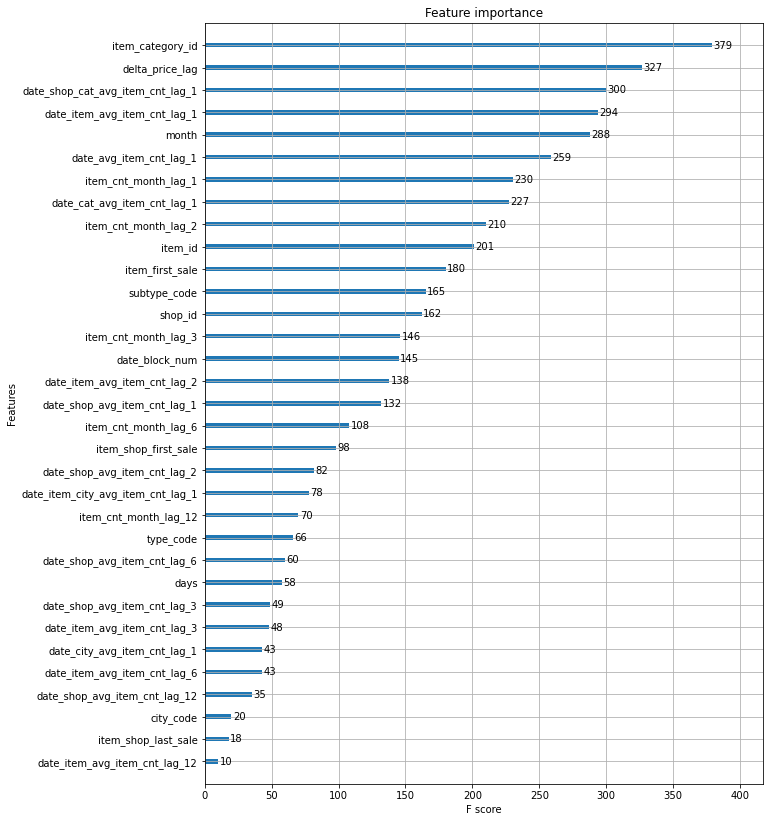

In [63]:
plot_features(model, (10,14))